In [139]:
import kwant
import matplotlib.pyplot as plt
import numpy as np
from ccode.finite_system import finite_system
import scipy.sparse.linalg as sla
import ccode.tools as tl
from ccode.boundstate import find_boundstates, extract_boundstates
import time
import dask.bag as db
from dask_quantumtinkerer import Cluster, cluster_options
import itertools as it
from scipy.signal import find_peaks
import pickle
%matplotlib inline
plt.rcParams.update({"font.size": 15})

In [2]:
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [3]:
params = tl.junction_parameters(m_nw=np.array([-2, 0, -2]), m_qd=-2, bx=0.011)
a = params['a']

### Cluster configuration

In [4]:
options = cluster_options()
options.worker_cores = 1  # you should always leave this to 1 (I think)
options.worker_memory = 2  # Need to atdjust this to meet your needs
options.extra_path = "/home/jtorresluna/work/trijunction_design/"  # Make sure to do this if you import any local modules!

In [5]:
cluster = Cluster(options)

In [6]:
cluster

In [7]:
print(
    "http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"
    + cluster.dashboard_link[17:]
)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/b4db5e0276b044e589babd93c0466902/status


In [8]:
client = cluster.get_client()

In [150]:
cluster.close()

# Triangular trijunctions with different angles

## Set up geometries

In [9]:
geometry = {
"A": 500*a**2,
"angle": np.pi/5,
"l": 70*a,
"w": 7*a,
"a": a,
"side": 'up',
"shape": 'triangle'
}

In [10]:
n_angles = 7
angles = np.linspace(0.1, 0.4, n_angles)

In [11]:
tjs = []
for angle in angles:
    geometry.update(angle=angle*np.pi)
    trijunction, f_params = finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

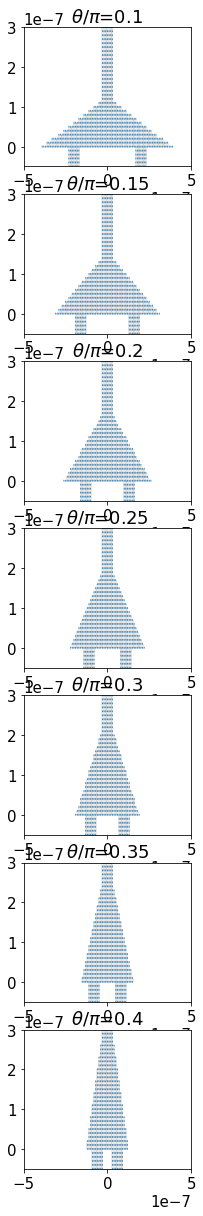

In [12]:
fig, ax = plt.subplots(nrows=n_angles, ncols=1, figsize=(3, 3*n_angles))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-0.5e-7, 3e-7)
    axes.set_xlim(-5e-7, 5e-7)
    axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

## Calculation

In [145]:
# index is used to choose the sub band of a wire of width 7*a
index = 4
params = tl.finite_coupling_parameters(index=index)
title = 'trijunction angle dependence '+str(index)+'th band'

In [73]:
mus_qd = np.linspace(-0.011, 0.02, 200)
key = 'mu_qd'
n = 6
eigen = tl.solver(n=n, key=key)

In [74]:
def wrap(args):
    return eigen(*args)

In [75]:
args = list(it.product(tjs, mus_qd, params))
args_db = db.from_sequence(args, npartitions=20)

In [76]:
result = args_db.map(wrap).compute()

In [110]:
def average_energy_levels(mus, result):
    geometry_data = []
    ens, _, peaks = tl.coupling_data(result, n=6)

    for k in range(3):
        single_average = []
        single_mus = []
        single_widths = []
        single_peaks = np.hstack([0, peaks[k], -1])
        indices_intervals = zip(single_peaks, single_peaks[1:])

        for i, j in indices_intervals:
            energy_section = np.abs(ens[k])[i:j]
            ediff = np.abs(mus[j]-mus[i])
            average = np.sum(energy_section)/np.abs(ediff)
            single_average.append(average)
            single_mus.append(mus[i]+ediff/2)
            single_widths.append(ediff)

        geometry_data.append([single_mus, single_average, single_widths])

    return np.array(geometry_data)

In [111]:
data = []
data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_angles)
for geometry in data_geometries:
    data.append(average_energy_levels(mus=mus_qd, result=geometry))

In [146]:
with open('../data/'+title.replace(' ', '_')+'.pickle', 'wb') as file:
    pickle.dump(data, file)

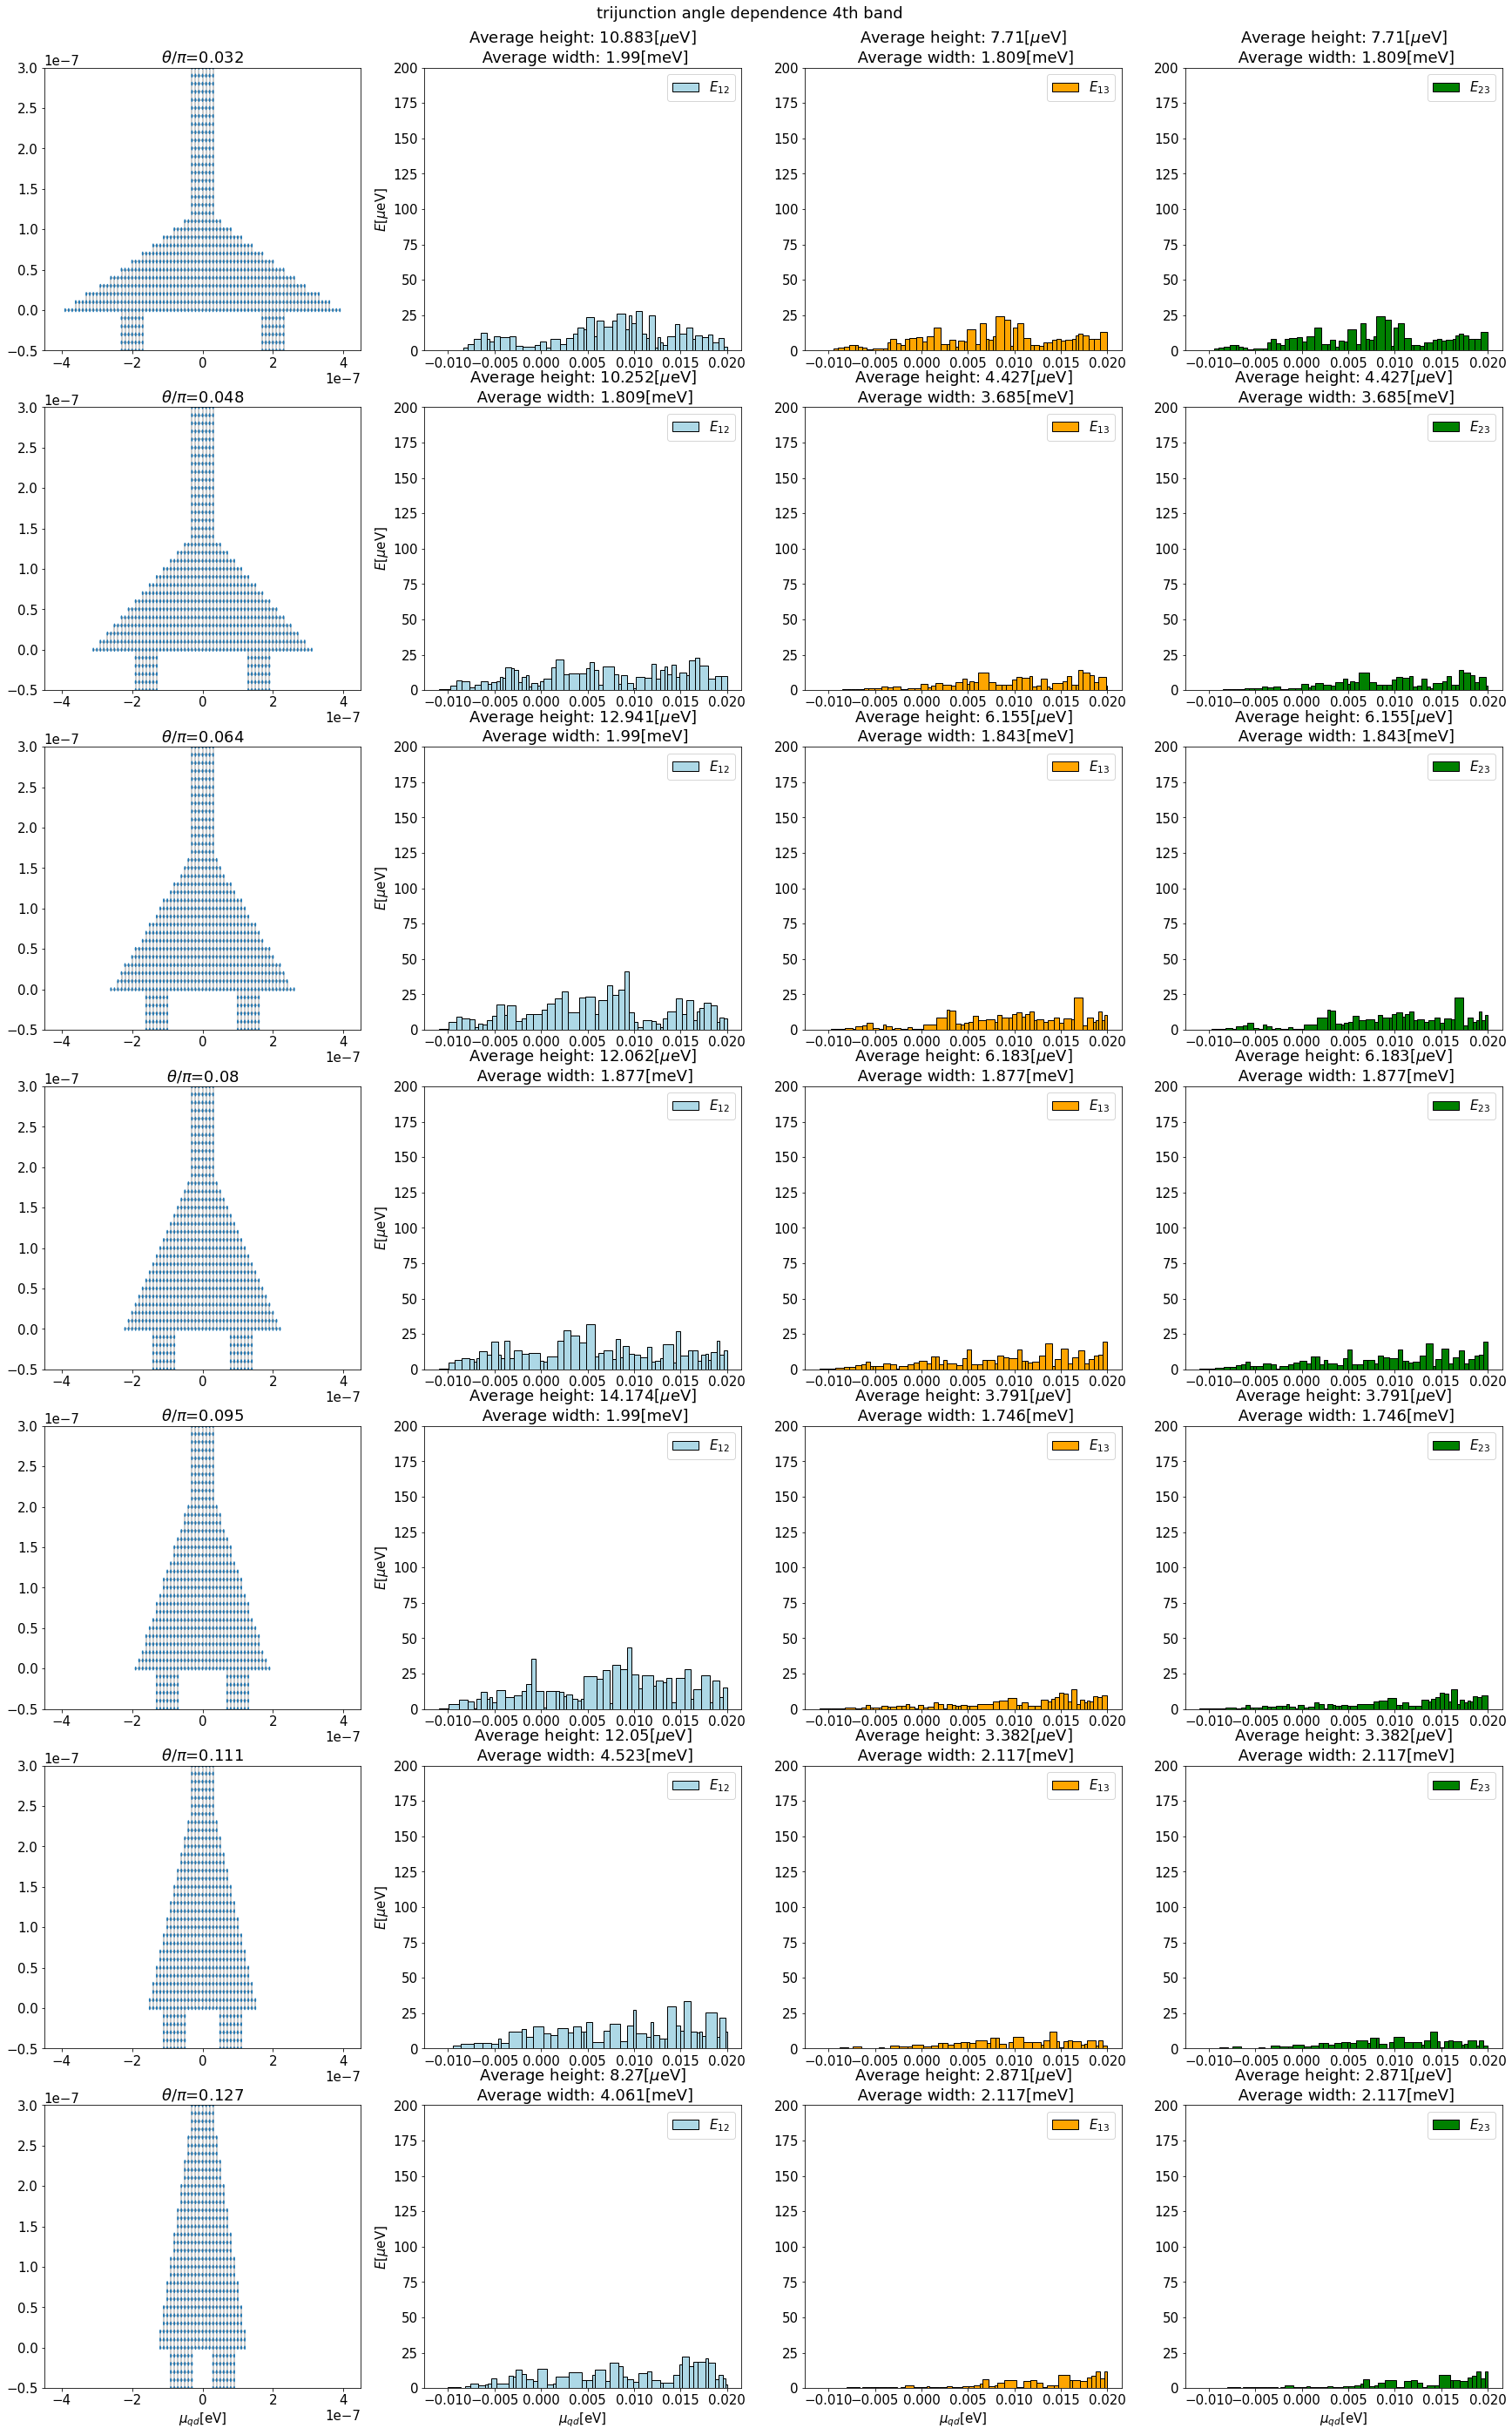

In [149]:
fig, ax = plt.subplots(ncols=4, nrows=n_angles, figsize=(30, 7*n_angles))
fig.suptitle(title, y=0.9)
labels = [r'$E_{12}$', r'$E_{13}$', r'$E_{23}$']
colors = ['lightblue', 'orange', 'green']
g = 0
for i in range(n_angles):
    for j in range(4):
        if j == 0:
            kwant.plot(tjs[i][0], ax=ax[i][j])
            ax[i][j].set_ylim(-0.5e-7, 3e-7)
            ax[i][j].set_xlim(-4.5e-7, 4.5e-7)
            ax[i][j].set_title(r'$\theta/\pi$='+str(np.round(angles[i]/np.pi, 3)))
        if j > 0:
            w = j-1
            mus = data[i][w][0]
            bars = 100*np.array(data[i][w][1])
            widths = data[i][w][2]
            average_peak_width = np.round(np.mean(widths)/np.min(widths), 3)
            average_peak_height = np.round(np.mean(bars), 3)
            ax[i][j].bar(mus, bars, width=widths, label=labels[w], edgecolor='black', color=colors[w])
            ax[i][j].set_ylim(0, 200)
            title_subplots = r'Average height: '+str(average_peak_height)+'[$\mu$eV]\n Average width: '+str(average_peak_width)+'[meV]'
            ax[i][j].set_title(title_subplots)
            ax[i][j].legend()
        if j == 1:
            ax[i][j].set_ylabel(r'$E[\mu$eV]')
        if i == n_angles-1:
            ax[i][j].set_xlabel(r'$\mu_{qd}$[eV]')  
    g += 1
plt.savefig('../data/'+title.replace(' ', '_')+'.svg')